In [1]:
def unpickle(file):
    import cPickle
    with open(file, 'rb') as fo:
        dict = cPickle.load(fo)
    return dict

In [2]:
batch_1 = unpickle('cifar-10-batches-py/data_batch_1')

In [3]:
X_train = batch_1['data']
X_train.shape

(10000, 3072)

In [4]:
Y_train = batch_1['labels']
len(Y_train)

10000

#### data
A 10000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.
#### labels
A list of 10000 numbers in the range 0-9. The number at index i indicates the label of the ith image in the array data.

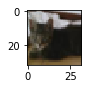

In [5]:
import matplotlib.pyplot as plt
import scipy
import scipy.misc
%matplotlib inline
import numpy as np
%matplotlib inline
plt.figure(figsize =(1,1))
image = np.swapaxes(X_train[9].reshape(32, 32, 3, order='F'), 0,1)
image = scipy.misc.imresize(image, (32,32)) 
plt.imshow(image)

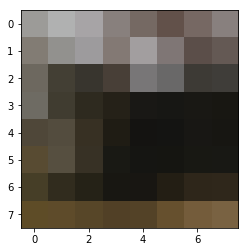

In [6]:
image = np.swapaxes(X_train[9].reshape(32, 32, 3, order='F'), 0,1)
image = scipy.misc.imresize(image, (8,8)) 
plt.imshow(image)

In [7]:
def leaky_relu_and_bn(X, alpha=0.3):
    X = tf.layers.batch_normalization(X)
    return tf.nn.relu(X) - alpha * tf.nn.relu(-X)

In [8]:
import tensorflow as tf
tf.reset_default_graph()

def from_rgb(X):
    Xn = tf.layers.batch_normalization(X)
    w_1 = tf.get_variable('from_rgb_w1', [1, 1, 3, 16], initializer=tf.truncated_normal_initializer(stddev=np.sqrt(2.0 / 16)))
    b_1 = tf.get_variable('from_rgb_b1', [16], initializer = tf.truncated_normal_initializer(stddev=0.02))
    l_1a = tf.nn.conv2d(Xn, w_1, [1,1,1,1], padding='SAME') + b_1;
    l_1b = leaky_relu_and_bn(l_1a)

    w_2 = tf.get_variable('from_rgb_w2', [3, 3, 16, 16], initializer=tf.truncated_normal_initializer(stddev=np.sqrt(2.0 / 16)))
    b_2 = tf.get_variable('from_rgb_b2', [16], initializer = tf.truncated_normal_initializer(stddev=0.02))
    l_2a = tf.nn.conv2d(l_1b, w_2, [1,1,1,1], padding='SAME') + b_2;
    l_2b = leaky_relu_and_bn(l_2a)

    w_3 = tf.get_variable('from_rgb_w3', [3, 3, 16, 32], initializer=tf.truncated_normal_initializer(np.sqrt(2.0 / 16)))
    b_3 = tf.get_variable('from_rgb_b3', [32], initializer = tf.truncated_normal_initializer(stddev=0.02))    
    l_3a = tf.nn.conv2d(l_2b, w_3, [1,1,1,1], padding='SAME') + b_3;
    l_3b = leaky_relu_and_bn(l_3a)

    return tf.nn.avg_pool(l_3b, [1, 2, 2, 1], [1, 1, 1, 1], padding='SAME')

In [9]:
num_images_before_adding_block = 100
def calculate_num_blocks_to_add_and_smoothing_coefficient(num_images_seen):
    i = num_images_seen
    n = num_images_before_adding_block
    num_blocks_to_add = (int)(i / n)
    r = i - num_blocks_to_add * num_images_before_adding_block
    smoothing_coefficient = np.min([1, r / (n / 2.0)])
    return [num_blocks_to_add, smoothing_coefficient]

In [10]:
def new_d_block(X, num_channels):
    w_1 = tf.get_variable(str(num_channels) + '_w1', [3, 3, num_channels, num_channels], initializer=tf.truncated_normal_initializer(stddev=np.sqrt(2.0 / num_channels)))
    b_1 = tf.get_variable(str(num_channels) + '_b1', [num_channels], initializer = tf.truncated_normal_initializer(stddev=0.02))    
    conv_1 = tf.nn.conv2d(X, w_1, [1,1,1,1], padding='SAME', name=str(num_channels) + '_conv1') + b_1
    a_1 = leaky_relu_and_bn(conv_1)
    
    w_2 = tf.get_variable(str(num_channels) + '_w2', [3, 3, num_channels, 2 * num_channels], initializer=tf.truncated_normal_initializer(stddev=np.sqrt(2.0 / num_channels)))
    b_2 = tf.get_variable(str(num_channels) + '_b2', [num_channels], initializer = tf.truncated_normal_initializer(stddev=0.02))    
    conv_2 = tf.nn.conv2d(a_1, w_2, [1,1,1,1], padding='SAME', name=str(num_channels) + '_conv2') + b_2
    a_2 = leaky_relu_and_bn(conv_2)  
    
    return tf.nn.avg_pool(a_2, [1, 2, 2, 1], [1, 1, 1, 1], padding='SAME')

In [11]:
def discriminator(X, num_images_seen, reuse=False):
    with tf.variable_scope("D"):
        if (reuse):
            tf.get_variable_scope().reuse_variables()

        block = from_rgb(X)
        
        num_channels = 32
        num_blocks_to_add, smoothing_coefficient = calculate_num_blocks_to_add_and_smoothing_coefficient(num_images_seen)
        for i in range(num_blocks_to_add):
            block = new_d_block(block, i)
            num_channels = 2 * num_channels

        w_1 = tf.get_variable('final_w1', [3, 3, num_channels, num_channels], initializer=tf.truncated_normal_initializer(stddev=np.sqrt(2.0 / num_channels)))
        b_1 = tf.get_variable('final_b1', [num_channels], initializer = tf.truncated_normal_initializer(stddev=0.02))    
        final_1a = tf.nn.conv2d(block, w_1, [1,1,1,1], padding='SAME') + b_1
        final_1b = leaky_relu_and_bn(final_1a)

        w_2 = tf.get_variable('final_w2', [4, 4, num_channels, num_channels], initializer=tf.truncated_normal_initializer(stddev=np.sqrt(2.0 / num_channels)))
        b_2 = tf.get_variable('final_b2', [num_channels], initializer = tf.truncated_normal_initializer(stddev=np.sqrt(2.0 / num_channels)))    
        final_2a = tf.nn.conv2d(final_1b, w_2, [1,1,1,1], padding='VALID') + b_2
        final_2b = leaky_relu_and_bn(final_2a)
        return tf.layers.dense(final_2b, 1)

In [12]:
def to_rgb(X, starting_resolution, batch_size):   
    target_resolution = 2 * starting_resolution
    l0 = tf.image.resize_nearest_neighbor(X, [target_resolution, target_resolution], name="to_rgm_resize") 

    w_1 = tf.get_variable('to_rgb_w1', [3, 3, 16, 32], initializer=tf.truncated_normal_initializer(stddev=np.sqrt(2.0 / 32)))
    b_1 = tf.get_variable('to_rgb_b1', [16], initializer = tf.truncated_normal_initializer(stddev=np.sqrt(2.0 / 16)))
    l_1a = tf.nn.conv2d_transpose(l0, w_1, [batch_size, target_resolution, target_resolution, 16], [1,1,1,1], padding='SAME', name='to_rgb_l1') + b_1
    l_1b = leaky_relu_and_bn(l_1a)
    
    w_2 = tf.get_variable('to_rgb_w2', [3, 3, 16, 16], initializer=tf.truncated_normal_initializer(stddev=np.sqrt(2.0 / 16)))
    b_2 = tf.get_variable('to_rgb_b2', [16], initializer = tf.truncated_normal_initializer(stddev=0.02))
    l_2a = tf.nn.conv2d_transpose(l_1b, w_2, [batch_size, target_resolution, target_resolution, 16], [1,1,1,1], padding='SAME', name='to_rgb_l2') + b_2
    l_2b = leaky_relu_and_bn(l_2a)
    
    w_3 = tf.get_variable('to_rgb_w3', [1, 1, 3, 16], initializer=tf.truncated_normal_initializer(stddev=np.sqrt(2.0 / 16)))
    b_3 = tf.get_variable('to_rgb_b3', [3], initializer = tf.truncated_normal_initializer(stddev=0.02))
    return tf.nn.conv2d_transpose(l_2b, w_3, [batch_size, target_resolution, target_resolution, 3], [1,1,1,1], padding='SAME', name='to_rgb_l3') + b_3

In [13]:
def new_g_block(X, starting_resolution, num_channels):
    target_resolution = 2 * starting_resolution
    l0 = tf.image.resize_nearest_neighbor(X, [target_resolution, target_resolution], name="to_rgm_resize") 

    w_1 = tf.get_variable(str(target_resolution) + 'w1', [3, 3, num_channels / 2, num_channels], initializer=tf.truncated_normal_initializer(stddev=np.sqrt(2.0 / 32)))
    b_1 = tf.get_variable(str(target_resolution) + 'b1', [num_channels / 2], initializer = tf.truncated_normal_initializer(stddev=np.sqrt(2.0 / 16)))
    l_1a = tf.nn.conv2d_transpose(l0, w_1, [batch_size, size, size, 16], [1,1,1,1], padding='SAME', name=str(target_resolution) + 'deconv1') + b_1
    l_1b = leaky_relu_and_bn(l_1a)
    
    w_2 = tf.get_variable(str(target_resolution) + 'w2', [3, 3, num_channels / 2, num_channels / 2], initializer=tf.truncated_normal_initializer(stddev=np.sqrt(2.0 / 16)))
    b_2 = tf.get_variable(str(target_resolution) + 'b2', [num_channels / 2], initializer = tf.truncated_normal_initializer(stddev=0.02))
    l_2a = tf.nn.conv2d_transpose(l_1b, w_2, [batch_size, target_resolution, target_resolution, num_channels / 2], [1,1,1,1], padding='SAME', name=str(target_resolution) + 'deconv2') + b_2
    return leaky_relu_and_bn(l_2a)

In [14]:
def generator(z, num_images_seen, batch_size, reuse=False):
    with tf.variable_scope("G"):
        if (reuse):
            tf.get_variable_scope().reuse_variables()
        
        num_blocks_to_add, smoothing_coefficient = calculate_num_blocks_to_add_and_smoothing_coefficient(num_images_seen)
        zdim = 2 ** (5 + num_blocks_to_add)
        z_rehaped = tf.reshape(z, [batch_size, 1, 1, zdim], name='z_reshape')
        w_1 = tf.get_variable('initial_w1', [4, 4, zdim, zdim], initializer=tf.truncated_normal_initializer(stddev=np.sqrt(2.0 / zdim)))
        b_1 = tf.get_variable('initial_b1', [zdim], initializer = tf.truncated_normal_initializer(stddev=0.02))    
        initial_1a = tf.nn.conv2d_transpose(z_rehaped, w_1, [batch_size, 4, 4, zdim], [1, 1, 1, 1], padding='VALID', name='initial_l1') + b_1
        initial_1b = leaky_relu_and_bn(initial_1a)
        
        w_2 = tf.get_variable('initial_w2', [3, 3, zdim, zdim], initializer=tf.truncated_normal_initializer(stddev=np.sqrt(2.0 / zdim)))
        b_2 = tf.get_variable('initial_b2', [zdim], initializer = tf.truncated_normal_initializer(stddev=0.02))    
        initial_2a = tf.nn.conv2d_transpose(initial_1b, w_2, [batch_size, 4, 4, zdim], [1, 1, 1, 1], padding='SAME', name='initial_l2') + b_2
        block = leaky_relu_and_bn(initial_2a)

        resolution = 4
        num_channels = zdim
        for i in range(num_blocks_to_add):
            block = new_g_block(block, resolution, num_channels)
            resolution = resolution * 2
            num_channels = num_channels / 2
        
        return to_rgb(block, resolution, batch_size)

In [15]:
X = tf.placeholder(tf.float32, [None, None, None, 3], name="X")
z = tf.placeholder(tf.float32, [None, None], name="z")

In [16]:
batch_size = 32
zdim = 32

In [17]:
Dx = discriminator(X, 0)
Gz = generator(z, zdim, batch_size, False)
Dg = discriminator(Gz, 0, True)

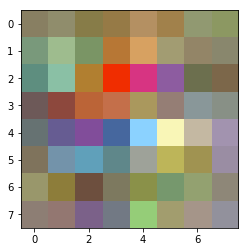

131.833333333
39.1979927916


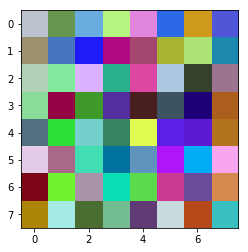

4.40772
13.3977490485


In [18]:
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    z_batch = np.random.normal(0, 1, size=[batch_size, zdim])
    generated_images = sess.run(Gz, feed_dict={z: z_batch})
    generated_image = generated_images[0, :, :, :]
    
    g1 = scipy.misc.imresize(generated_image, (8, 8))
    plt.imshow(g1)
    plt.show()
    print(np.mean(g1))
    print(np.var(g1) ** 0.5)

    g2 = generated_image.reshape(8, 8, 3, order='F')
    plt.imshow(g2)
    plt.show()
    print(np.mean(g2))
    print(np.var(g2) ** 0.5)


In [19]:
d_cost_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dx, labels=tf.ones_like(Dx)))
d_cost_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg, labels=tf.zeros_like(Dg)))
g_cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg, labels=tf.ones_like(Dg)))

In [20]:
tvars = tf.trainable_variables()
d_vars = [var for var in tvars if 'D/' in var.name]
g_vars = [var for var in tvars if 'G/' in var.name]

In [21]:
optimizer_d_real = tf.train.AdamOptimizer(learning_rate=0.001).minimize(d_cost_real, var_list=d_vars)
optimizer_d_fake = tf.train.AdamOptimizer(learning_rate=0.001).minimize(d_cost_fake, var_list=d_vars)
optimizer_g = tf.train.AdamOptimizer(learning_rate=0.001).minimize(g_cost, var_list=g_vars)

Target:


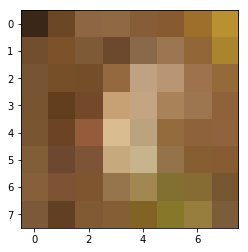

Target:


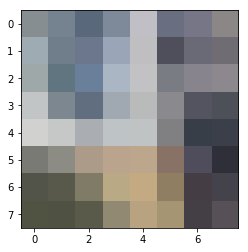

Target:


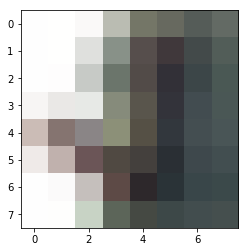

Target:


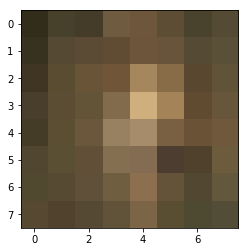

Target:


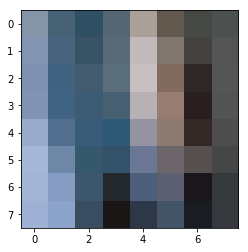

Target:


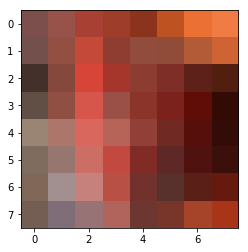

Target:


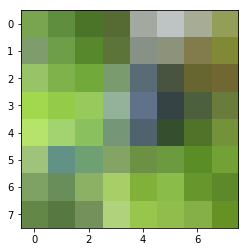

Target:


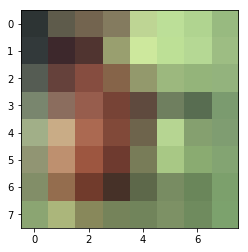

Target:


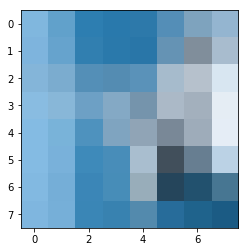

Target:


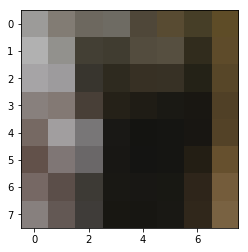

Target:


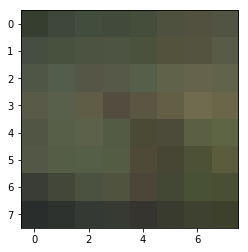

Target:


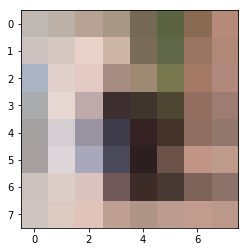

Target:


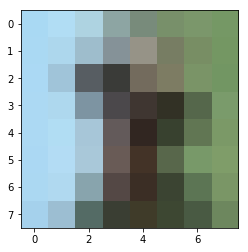

Target:


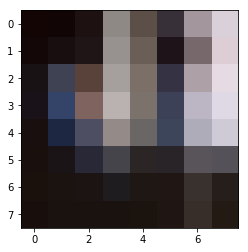

Target:


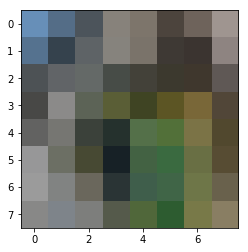

Target:


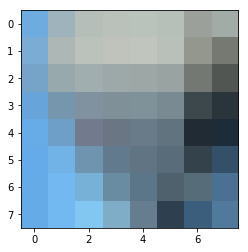

Target:


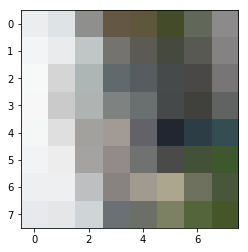

Target:


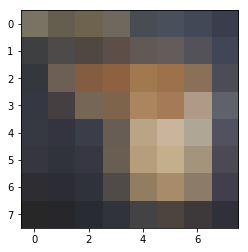

Target:


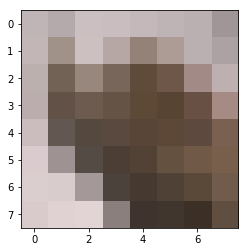

Target:


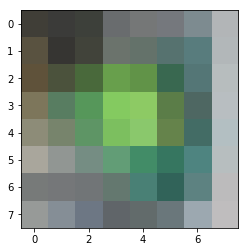

Target:


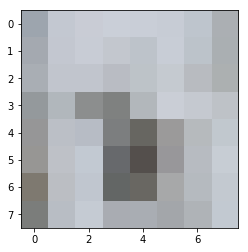

Target:


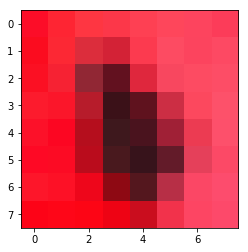

Target:


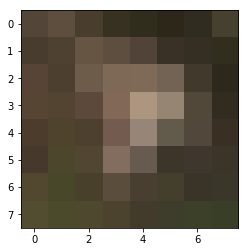

Target:


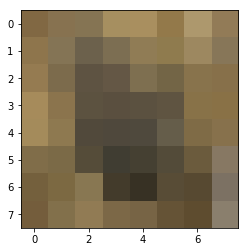

Target:


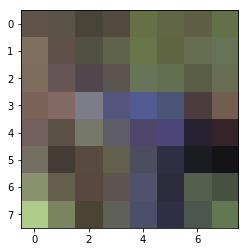

Target:


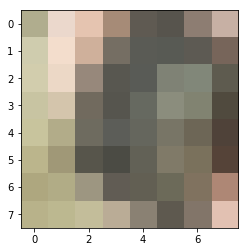

Target:


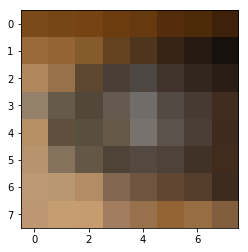

Target:


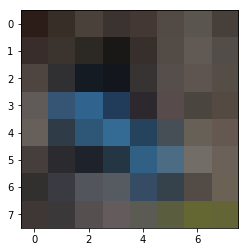

Target:


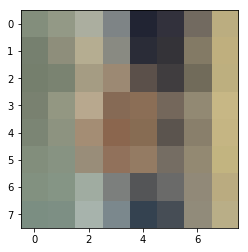

Target:


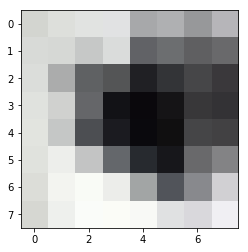

Target:


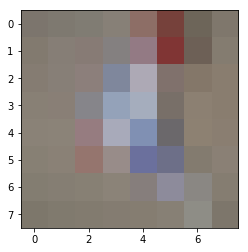

Target:


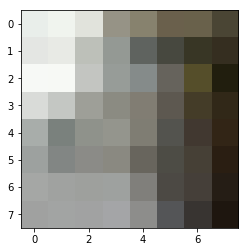

Generated:
# images seen: 0
Cost Real: 93370.4
Cost Fake: 0.00458735
g_cost:13748.1
Generated:


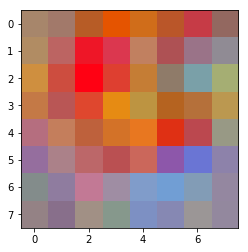

Generated:


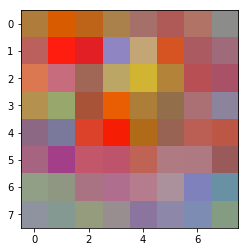

Generated:


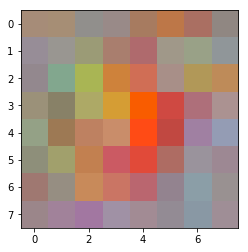

Generated:


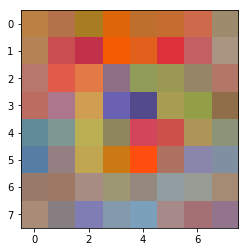

Generated:


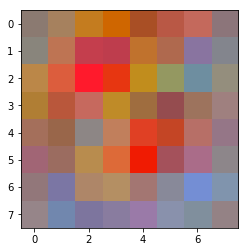

# images seen: 10000
Cost Real: 161.071
Cost Fake: 53.3048
g_cost:47.5964
Generated:


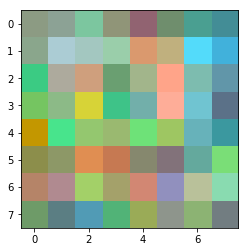

Generated:


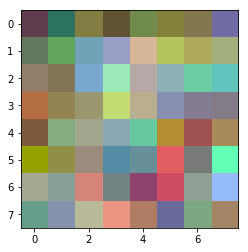

Generated:


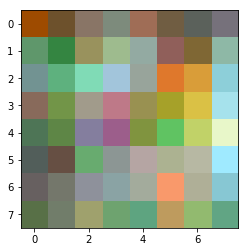

Generated:


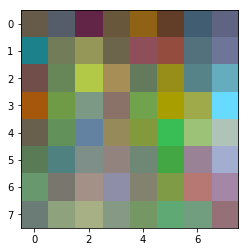

Generated:


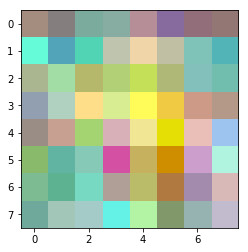

# images seen: 20000
Cost Real: 137.795
Cost Fake: 21.3899
g_cost:112.619
Generated:


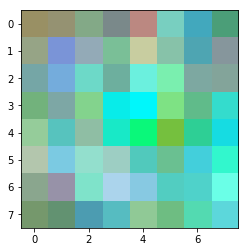

Generated:


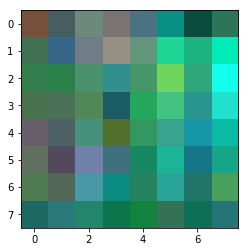

Generated:


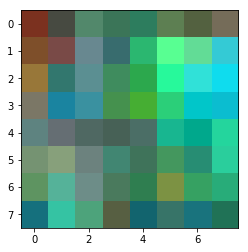

Generated:


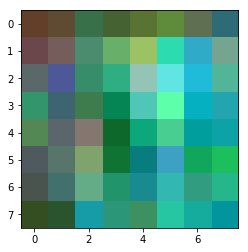

Generated:


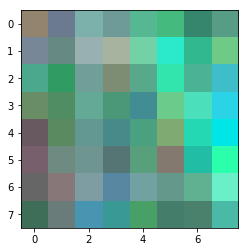

# images seen: 30000
Cost Real: 82.893
Cost Fake: 6.73998
g_cost:138.843
Generated:


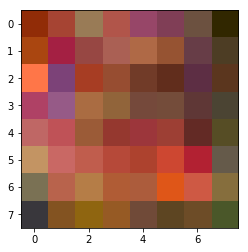

Generated:


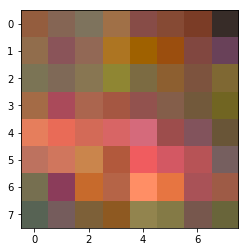

Generated:


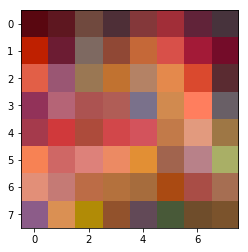

Generated:


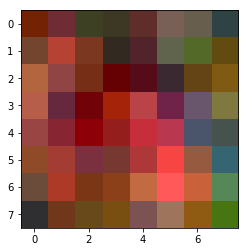

Generated:


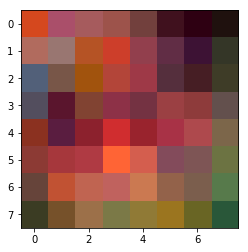

# images seen: 40000
Cost Real: 330.289
Cost Fake: 4.33547
g_cost:151.666
Generated:


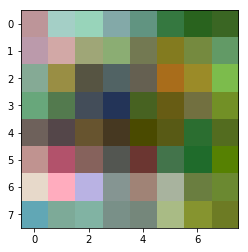

Generated:


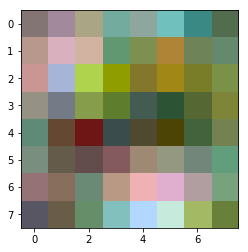

Generated:


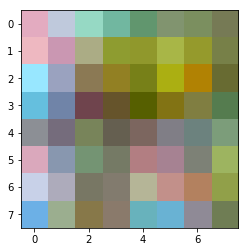

Generated:


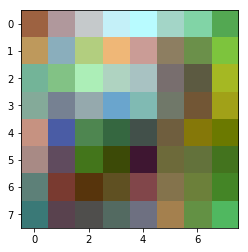

Generated:


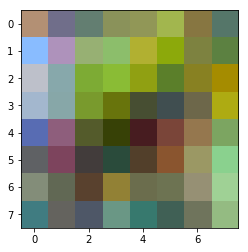

# images seen: 50000
Cost Real: 142.409
Cost Fake: 10.0259
g_cost:92.5846
Generated:


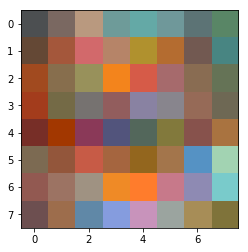

Generated:


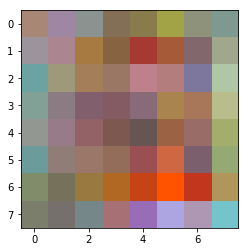

Generated:


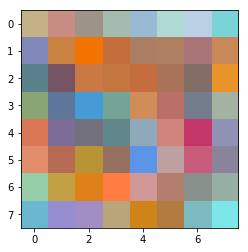

Generated:


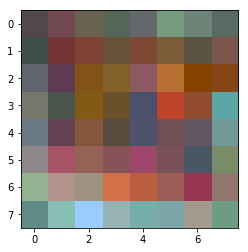

Generated:


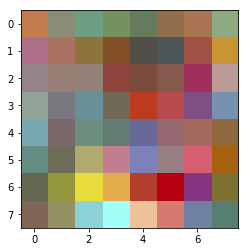

# images seen: 60000
Cost Real: 373.7
Cost Fake: 1.33142
g_cost:107.822
Generated:


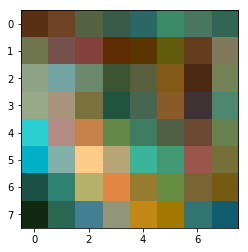

Generated:


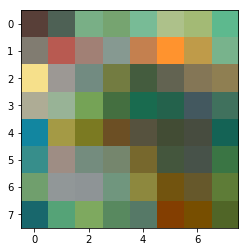

Generated:


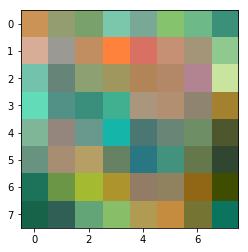

Generated:


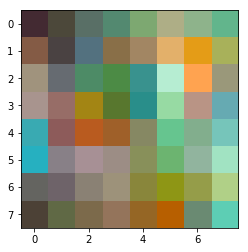

Generated:


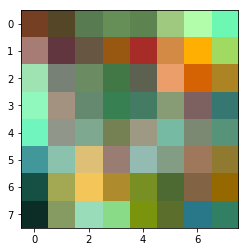

# images seen: 70000
Cost Real: 64.9035
Cost Fake: 8.29613
g_cost:36.3896
Generated:


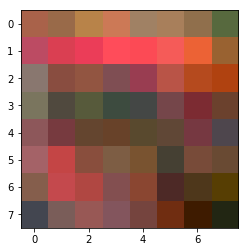

Generated:


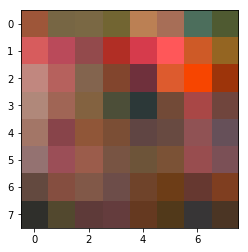

Generated:


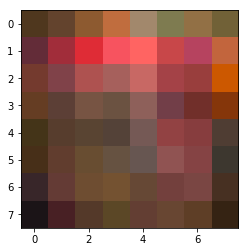

Generated:


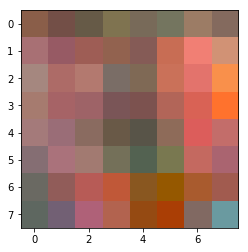

Generated:


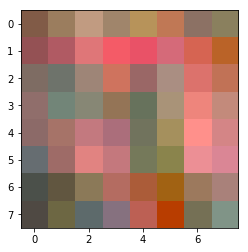

# images seen: 80000
Cost Real: 44.5868
Cost Fake: 1.11633
g_cost:68.2213
Generated:


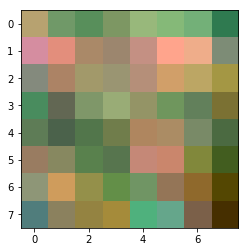

Generated:


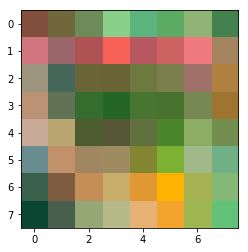

Generated:


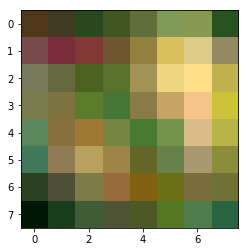

Generated:


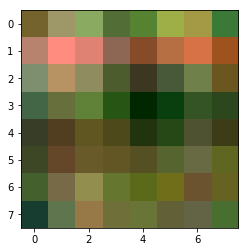

Generated:


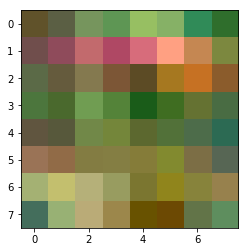

KeyboardInterrupt: 

In [22]:
num_epochs = 100000
verbose = True
sample = None
d_warm_up = 0
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    num_training_images = len(X_train)

    for im in X_train[0:batch_size]:
        print("Target:")
        plt.imshow(scipy.misc.imresize(im.reshape([32, 32, 3], order='F'), (8, 8,3)))
        plt.show()
    
    print("Generated:")
    
    for epoch in range(num_epochs):
        for i in range(0, X_train.shape[0], batch_size):
            num_images_seen = i * batch_size + num_training_images * epoch
            num_blocks_to_add, _ = calculate_num_blocks_to_add_and_smoothing_coefficient(num_images_seen)
            image_size = 2 ** (3 + num_blocks_to_add)
            original_real_batch = X_train[i:i + batch_size]
            real_batch = map(lambda(im): scipy.misc.imresize(im.reshape(32, 32, 3, order='F'), (8, 8,3)), original_real_batch)
            z_batch = np.random.normal(0, 1, size=[batch_size, zdim])
            _, __, cost_real, cost_fake = session.run([optimizer_d_real, optimizer_d_fake, d_cost_real, d_cost_fake], feed_dict={X: real_batch, z: z_batch })
            
            if num_images_seen >= d_warm_up:
                _, gen_cost = session.run([optimizer_g, g_cost], feed_dict={z: z_batch})
                if verbose and i % (100000 * batch_size) == 0:
                    print "# images seen: " + str(num_images_seen)
                    print "Cost Real: " + str(cost_real)
                    print "Cost Fake: " + str(cost_fake)
                    print "g_cost:" + str(gen_cost)
                    demo_batch_size = 5
                    z_batch = np.random.normal(0, 1, size=[demo_batch_size, zdim])
                    generated_images = generator(z, zdim, demo_batch_size, True)
                    images = session.run(generated_images, {z: z_batch})
                    sample = images[0]
                    for i, im in enumerate(images[0:demo_batch_size]):
                        print("Generated:")
                        plt.imshow(scipy.misc.imresize(im, (8, 8,3)))
                        plt.show()